In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

### Level 1 - Solve the acoustic isotropic wave equation in 1D with absorbing boundary conditions and a point source

[Acoustic Isotropic Wave Equation](http://sepwww.stanford.edu/sep/prof/bei/fdm/paper_html/node40.html#SECTION00180000000000000000):
$$
\frac{1}{c^2}\frac{\partial^2 u}{\partial t^2} = \nabla^2 u + f
$$

Where $u$ is pressure, $t$ is time, $\nabla^2$ is the Laplacian and $f$ is a forcing function (acoustic source).
In one-dimension, this looks like:

$$
\frac{1}{c^2}\frac{\partial^2 u}{\partial t^2} = \frac{\partial^2 u}{\partial x^2} + f
$$

And can be solved using the finite-difference method as follows:

$$
\frac{1}{c^2} \frac{u_i^{t+1} - 2u_i^{t} + u_i^{t-1}}{\Delta t^2} = \frac{1}{\Delta x^2} \left(a_0 u_{i}^{t} + \sum_{n=1}^{M/2} \left( u_{i-n}^{t} - u_{i+n}^{t} \right) \right) + f
$$

This uses a second-order trapezoidal integration in time, which for hyperbolic PDEs is sufficient, $a$ represents a vector of Taylor Series coefficients and M is the spatial order. This is solved for $u_i^{t+1}$ in the interior ($M/2 \lt i \le NX-M/2$, $M/2 \lt j \le NY-M/2$, $M/2 \lt k \le NZ-M/2$).

We apply a [one-way wave equation at the boundaries](https://www.mdpi.com/2624-599X/2/1/12) ($i \le M/2, i \gt NX-M/2, j \le M/2, j \gt NY-M/2, k \le M/2, i \gt NZ-M/2$) as our absorbing boundary condition by factorizing the acoustic wave equation into forward ($c_+$) and backward ($c_-$) directions:

$$
\left( \frac{\partial^2}{\partial t^2} - c^2\frac{\partial^2}{\partial x^2} \right) u = 
\left( \frac{\partial}{\partial t} - c\frac{\partial}{\partial x} \right)\left( \frac{\partial}{\partial t} + c\frac{\partial}{\partial x} \right) u = 0
$$

Which is tantamount to an upwind and downwind discretisation at the boundaries to usher the wavefield out of the domain while preventing transfer of information back into the domain.

In [2]:
NX = 512
NT = 1000

ORDER  = 8
VEL    = 1000.
C_CRIT = 0.3

DX = 10.
DT = C_CRIT * DX / VEL

L = NX * DX
T = NT * DT

In [3]:
def init_src_wavelet(dt):
    df = 0.1
    fmin = 2.
    fmax = 12.
    ntsource = int(150)
    nf = int((fmax-fmin)/df)+1
    if (nf%2==0):
        nf += 1
    ifctr = int(nf/2)+1
    source = np.zeros(2*ntsource+1)
    for ifreq in range(1,nf+1):
        f = fmin + (ifreq-1)*df
        watef = 0.5 + 0.5*np.cos(np.pi*(ifreq-ifctr)/float(ifctr))
        watef = watef**(1/3)
        for it in range(-ntsource,ntsource+1):
            source[it+ntsource] += np.cos(2*np.pi*f*it*dt)*watef;
        
    for it in range(-ntsource,ntsource+1):
        source[it+ntsource] *= 0.5 + 0.5*np.cos(np.pi*it/float(ntsource))
    return source

In [4]:
def first_order_taylor_coefficients(spatial_order):
    if spatial_order == 2:
        return np.array([1.])
    elif spatial_order == 4:
        return np.array([27., -1.])/24.
    elif spatial_order == 6:
        return np.array([2250., -125., 9.])/1920.
    elif spatial_order == 8:
        return np.array([128625., -8575., 1029., -75.])/107520.
    elif spatial_order == 10:
        return np.array([12502350., -926100., 142884., -18225., 1225.])/10321920.
    elif spatial_order == 12:
        return np.array([1109375190., -88045650., 15848217., -2695275., 326095., -19845.])/908328960.
    else:
        raise ValueError("Order not yet implemented")
        
def second_order_taylor_coefficients(spatial_order):
    # zeroth fd-coefficients multiplied by ndim for each dimension
    if spatial_order==2:
        return np.array([-2.,1.])
    elif spatial_order==4:
        return np.array([-5./2.,4./3.,-1./12.])
    elif spatial_order==6:
        return np.array([-49./18.,3./2.,-3./20.,1./90.])
    elif spatial_order==8:
        return np.array([-205./72.,8./5.,-1./5.,8./315.,-1./560.])
    else:
        raise ValueError("Order not yet implemented")

In [5]:
@njit
def abc1d(u1,u2,v, rad, istart, inc):
    # v expects to be v*dt/dx
    v_coef = (1-v)/(1+v)
    
    ind_prev = istart
    ind_curr = istart + inc
    
    u2_prev = u2[ind_prev]
    u1_prev = u1[ind_prev]
    
    for i in range(rad):
        u1_curr = u1[ind_curr]
        u2_curr = v_coef*(u1_curr - u2_prev) + u1_prev
        u2[ind_curr] = u2_curr
        
        u2_prev = u2_curr
        u1_prev = u1_curr
        ind_prev = ind_curr
        ind_curr += inc
    return

In [6]:
@njit
def iso_timestep1d(u1,u2,vel2,nx,spatial_order,coeffs):
    # calculate the laplacian in the spatial domain
    # ! Does not require allocation of laplacian array
    # ! using this re-jigging
    stencil_rad = int(spatial_order/2)
    for i in range(stencil_rad,nx-stencil_rad):
        lap = coeffs[0]*u1[i]
        for j in range(1,stencil_rad+1):
            lap += coeffs[j]*(u1[i+j] + u1[i-j])
        u2[i] = 2*u1[i] - u2[i]  + vel2 * lap
    return

In [7]:
def extrapolate1d(u1,u2,vel,dx,dt,nx,nt,source,spatial_order):
    boundary_rad = spatial_order // 2
    coeffs = second_order_taylor_coefficients(spatial_order)
    vel *= dt/dx; vel *= vel
    for i in range(nt):
        u1,u2=u2,u1; assert u1 is not u2
        iso_timestep1d(u1,u2,vel,nx,spatial_order,coeffs) # calculate laplacian in spatial domain and timestep
        abc1d(u1,u2,np.sqrt(vel), boundary_rad, boundary_rad,     -1)  # left
        abc1d(u1,u2,np.sqrt(vel), boundary_rad, nx-boundary_rad-1,+1)  # right
        if i<len(source):
            u2[nx//5] += source[i] # add forcing function
        if i%100==0: 
            plt.plot(u2)
            plt.ylim([-1500.,+1500])
            plt.show()
    return

Domain length = 5120.0 m, 
         Propagating for T = 3.0 s, 
         in velocity model of V = 1000.0 m/s,
         using Finite-Difference Order = 8,
         Grid params: NX = 512, NT = 1000,
         DX = 10.0 m, DT = 3.000 ms, COURANT = 0.30


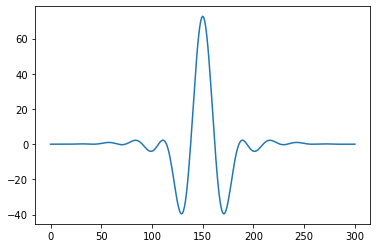

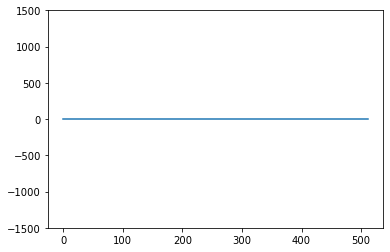

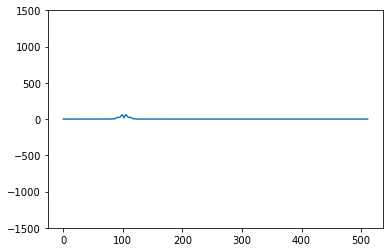

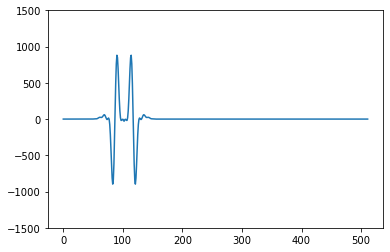

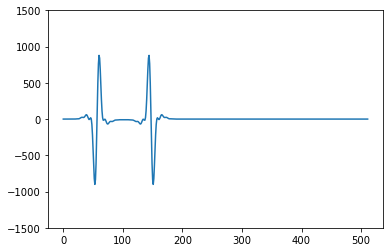

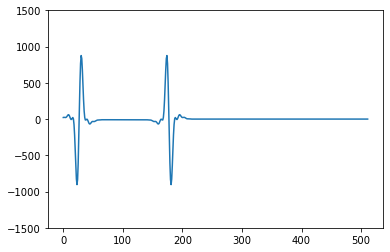

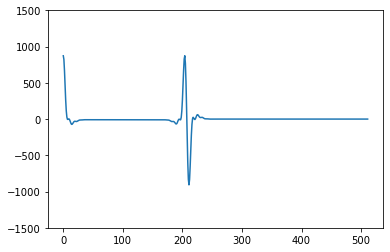

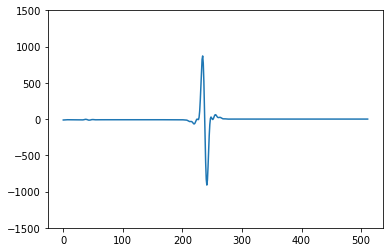

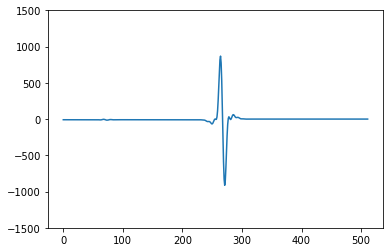

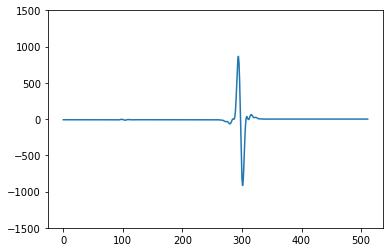

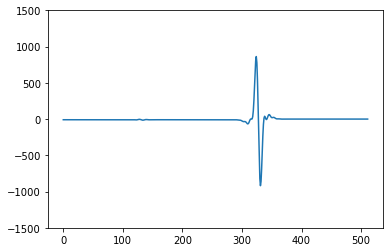

In [8]:
SOURCE = init_src_wavelet(DT)
print("""Domain length = %.1f m, 
         Propagating for T = %.1f s, 
         in velocity model of V = %.1f m/s,
         using Finite-Difference Order = %d,
         Grid params: NX = %d, NT = %d,
         DX = %.1f m, DT = %.3f ms, COURANT = %.2f""" % (L,T,VEL,ORDER,NX,NT,DX,DT*1e3,C_CRIT))

plt.plot(SOURCE); plt.show()

print("="*100)
u1 = np.zeros(NX)
u2 = np.zeros(NX)
extrapolate1d(u1,u2,VEL,DX,DT,NX,NT,SOURCE,ORDER)

### Level 2 - Solve the acoustic isotropic wave equation in 1D with absorbing boundary conditions and a point source

In three dimensions, the acoustic isotropic wave equation looks like:

$$
\frac{1}{c^2} \frac{u_{i,j,k}^{t+1} - 2u_{i,j,k}^{t} + u_{i,j,k}^{t-1}}{\Delta t^2} = \frac{1}{\Delta x^2} \left(\nabla_x^2 u + \nabla_y^2 u + \nabla_z^2 u \right) + f
$$

Where:

$$
\begin{aligned}
\nabla_x^2 u &= \left(a_0 u_{i,j,k}^{t} + \sum_{n=1}^{M/2} a_n \left( u_{i-n,j,k}^{t} - u_{i+n,j,k}^{t} \right) \right) \\
\nabla_y^2 u &= \left(a_0 u_{i,j,k}^{t} + \sum_{n=1}^{M/2} a_n \left( u_{i,j-n,k}^{t} - u_{i,j+n,k}^{t} \right) \right) \\
\nabla_z^2 u &= \left(a_0 u_{i,j,k}^{t} + \sum_{n=1}^{M/2} a_n \left( u_{i,j,k-n}^{t} - u_{i,j,k+n}^{t} \right) \right) \\
\end{aligned}
$$

The one-way wave equation remains one-dimensional, and is applied in one-dimension at each boundary point, orthoganal to the boundary plane at which the point sits.

In [9]:
@njit
def abc3d(u1,u2,v, nx,ny,nz, rad):
    # do 12(xy)-planes
    for j in range(ny):
        for i in range(nx):
            abc1d(u1[i,j,:], u2[i,j,:], v, rad, rad,      -1)
            abc1d(u1[i,j,:], u2[i,j,:], v, rad, nz-rad-1, +1)
    # do 23(yz)-planes
    for k in range(nz):
        for j in range(ny):
            abc1d(u1[:,j,k], u2[:,j,k], v, rad, rad,      -1)
            abc1d(u1[:,j,k], u2[:,j,k], v, rad, nx-rad-1, +1)
    # do 13(xz)-planes
    for k in range(nz):
        for i in range(nx):
            abc1d(u1[i,:,k], u2[i,:,k], v, rad, rad,      -1)
            abc1d(u1[i,:,k], u2[i,:,k], v, rad, ny-rad-1, +1)
    return

In [10]:
@njit
def iso_timestep3d(u1,u2,vel2,nx,ny,nz,spatial_order,coeffs):
    # calculate the laplacian in the spatial domain
    # and integrate forward in time
    stencil_rad = spatial_order//2
    for k in range(stencil_rad,nz-stencil_rad):
        for j in range(stencil_rad,ny-stencil_rad):
            for i in range(stencil_rad,nx-stencil_rad):
                lap = coeffs[0]*u1[i,j,k]*3. # three-dimensions
                for c in range(1,stencil_rad+1):
                    lap += coeffs[c]*(u1[i+c,j,k] + u1[i-c,j,k] 
                                    + u1[i,j+c,k] + u1[i,j-c,k] 
                                    + u1[i,j,k+c] + u1[i,j,k-c])
                u2[i,j,k] = 2.*u1[i,j,k] - u2[i,j,k] + vel2 * lap
    return

In [11]:
def iso_extrapolate3d(u1,u2,vel,dx,dt,nx,ny,nz,nt,source,spatial_order):
    
    boundary_rad = spatial_order
    coeffs = second_order_taylor_coefficients(boundary_rad)
    vel *= dt/dx; vel *= vel
    for it in range(nt):
        
        u1,u2 = u2,u1; assert u1 is not u2
        iso_timestep3d(u1,u2,vel,nx,ny,nz,spatial_order,coeffs) # calculate laplacian in spatial domain and timestep
        abc3d(u1,u2,np.sqrt(vel), nx,ny,nz, boundary_rad)
        
        if it<len(source):
            u1[nx//2,ny//2,nz//2] += source[it] # add forcing function

        if it%50==0:
            print(f'Timestep = {it}')
            plt.imshow(u2[:,:,nz//2], vmin=-1., vmax=+1.)
            plt.colorbar()
            plt.show()
    return


Domain length = 1280.0 m, 
Propagating for T = 3.1 s, 
in velocity model of V = 1000.0 m/s,
using Finite-Difference Order = 8,
Grid params: NX = 128, NT = 1024,
DX = 10.0 m, DT = 3.000 ms, COURANT = 0.30



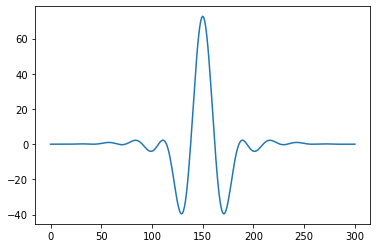

Timestep = 0


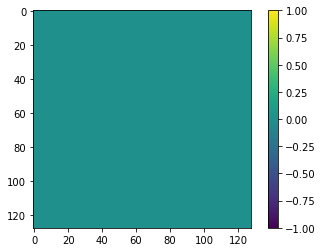

Timestep = 50


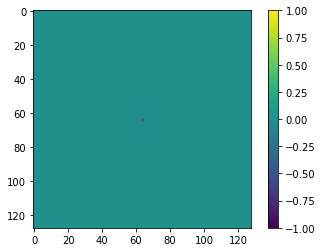

Timestep = 100


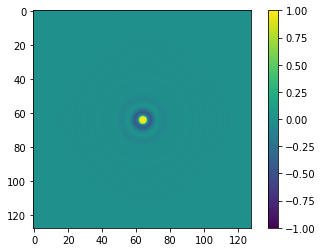

Timestep = 150


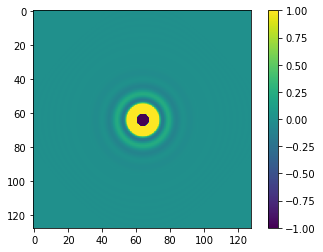

Timestep = 200


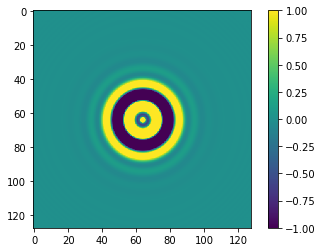

Timestep = 250


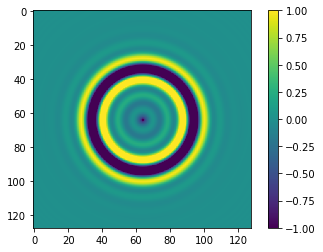

Timestep = 300


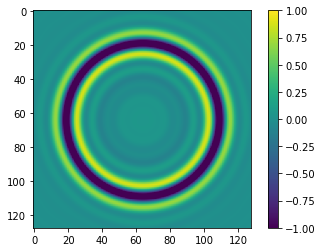

Timestep = 350


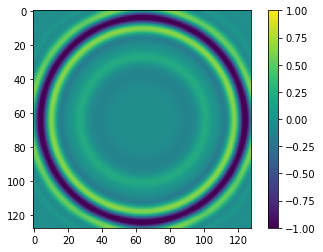

Timestep = 400


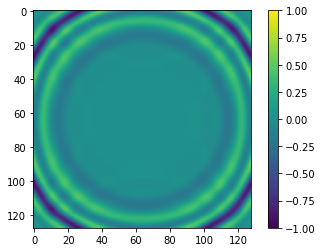

Timestep = 450


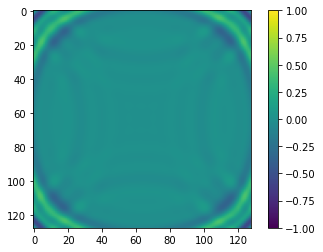

Timestep = 500


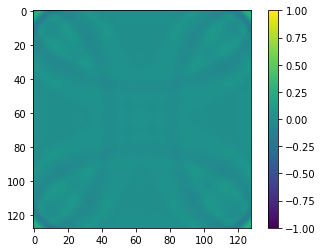

Timestep = 550


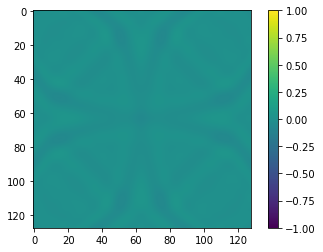

Timestep = 600


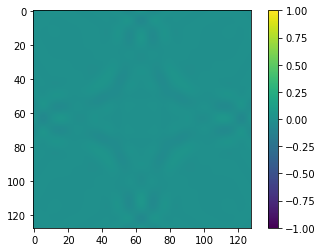

Timestep = 650


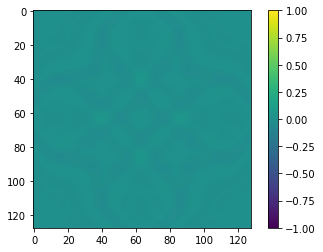

Timestep = 700


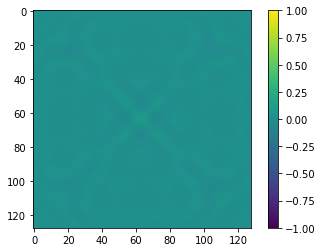

Timestep = 750


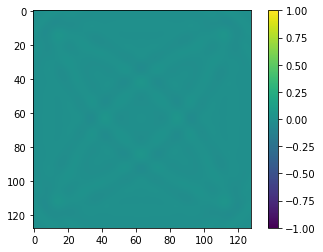

Timestep = 800


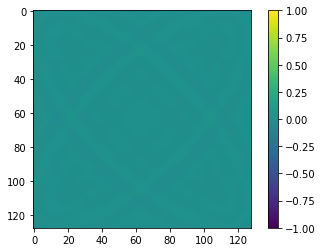

Timestep = 850


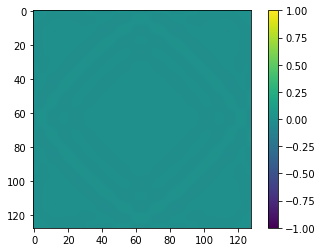

Timestep = 900


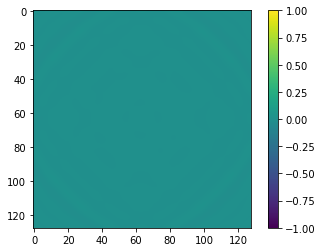

Timestep = 950


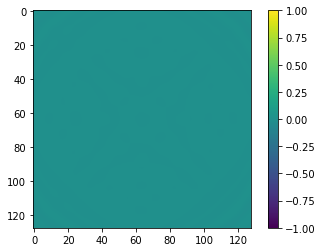

Timestep = 1000


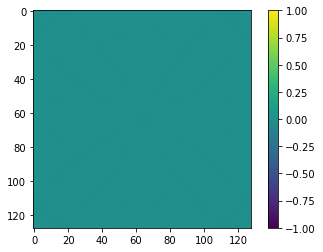

In [12]:
NX = int(128)
NY = int(128)
NZ = int(64)
NT = int(1024)

ORDER  = 8
VEL    = 1000.
C_CRIT = 0.3

DX = 10.
DY = 10.
DT = C_CRIT * DX / VEL

L = NX * DX
T = NT * DT

print("""
Domain length = %.1f m, 
Propagating for T = %.1f s, 
in velocity model of V = %.1f m/s,
using Finite-Difference Order = %d,
Grid params: NX = %d, NT = %d,
DX = %.1f m, DT = %.3f ms, COURANT = %.2f
""" % (L,T,VEL,ORDER,NX,NT,DX,DT*1e3,C_CRIT))

SOURCE = init_src_wavelet(DT)
plt.plot(SOURCE); plt.show()

u1 = np.zeros((NX,NY,NZ))
u2 = np.zeros((NX,NY,NZ))
iso_extrapolate3d(u1,u2,VEL,DX,DT,NX,NY,NZ,NT,SOURCE,ORDER)

### Solve the isotropic, variable-density (heterogeneous) wave equation in 3D with absorbing boundary conditions and a point source

Previously, we assumed that density was constant, and could therefore be factorised out of the derivative and applied directly to cancel the leading density term that's applied to the Laplacian, as in the homogeneous acoustic isotropic wave equation above. However, this is invalid in effectively all real-world scenarios, so we must consider the effect density has on the first partial derivative. To do this, we use a staggered grid approach to calculate the first derivative at half-grid points, apply density (actually buoyancy, the inverse of density) at these half-grid points, then take another first derivative of these half-grid derivatives back at the full-grid point.

The derivation I tend to use is that by [Bartolo, et al., 2012](https://doi-org.iclibezp1.cc.ic.ac.uk/10.1190/geo2011-0345.1) , which is in fact a reformulation of the standard cascaded approach described by [Etgen & Obrien, 2007](https://doi.org/10.1190/1.2753753). The difference being that we don't have to store intermediate wavefields, instead preferring to interpolate buoyancy to half-grid points on the fly.

The equation of interest is:

$$
\begin{align}
    \frac{1}{c^2\rho}\frac{\partial^2u}{\partial t^2} &=  \nabla\cdot\left(\frac{1}{\rho}\nabla u \right) \\
    \frac{\partial^2u}{\partial t^2} &= K\left[\frac{\partial}{\partial x}\left(\frac{1}{\rho}\frac{\partial u}{\partial x}\right)+ \ \frac{\partial}{\partial y}\left(\frac{1}{\rho}\frac{\partial y}{\partial y}\right)+\frac{\partial}{\partial z}\left(\frac{1}{\rho}\frac{\partial u}{\partial z}\right)\right]
\end{align}
$$

Which can be solved using a staggered-grid approach outlined by Bartolo, et al., 2012 (_cf_. Eq.23 & Appendix B1).

In [13]:
@njit
def iso_vd_timestep3d(u1,u2, buoy,kappa, nx,ny,nz, spatial_order, coeffs):
    # calculate the laplacian in the spatial domain
    # and integrate forward in time
    stencil_rad  = spatial_order // 2
    boundary_rad = spatial_order
    # nb. boundary conditions are now doubled as a staggered-grid doubles the stencil radius
    for k in range(boundary_rad,nz-boundary_rad):
        for j in range(boundary_rad,ny-boundary_rad):
            for i in range(boundary_rad,nx-boundary_rad):
                lap = 0.
                
                # the following three Laplacian calculations can be combined,
                # I've left them separate to highlight the repeated nature
                # of taking a staggered-grid derivative.
                
                # d2udx2
                for p2 in range(stencil_rad):
                    der_r = 0.
                    der_l = 0.
                    # du/d(+/-)x
                    for p1 in range(stencil_rad):
                        der_r += coeffs[p1]*(u1[i+p1+p2+1,j,k] - u1[i-p1+p2,j,k])
                        der_l += coeffs[p1]*(u1[i+p1-p2,j,k] - u1[i-p1-p2-1,j,k])
                    der_r *= (buoy[i+p2,j,k] + buoy[i+p2+1,j,k])/2.
                    der_l *= (buoy[i-p2-1,j,k] + buoy[i-p2,j,k])/2.
                    lap   += coeffs[p2] * (der_r - der_l)
                # d2udy2
                for p2 in range(stencil_rad):
                    der_r = 0.
                    der_l = 0.
                    # du/d(+/-)y
                    for p1 in range(stencil_rad):
                        der_r += coeffs[p1]*(u1[i,j+p1+p2+1,k] - u1[i,j-p1+p2,k])
                        der_l += coeffs[p1]*(u1[i,j+p1-p2,k] - u1[i,j-p1-p2-1,k])
                    der_r *= (buoy[i+p2,j,k] + buoy[i+p2+1,j,k])/2.
                    der_l *= (buoy[i-p2-1,j,k] + buoy[i-p2,j,k])/2.
                    lap   += coeffs[p2] * (der_r - der_l)
                # d2udz2
                for p2 in range(stencil_rad):
                    der_r = 0.
                    der_l = 0.
                    # du/d(+/-)z
                    for p1 in range(stencil_rad):
                        der_r += coeffs[p1]*(u1[i,j,k+p1+p2+1] - u1[i,j,k-p1+p2])
                        der_l += coeffs[p1]*(u1[i,j,k+p1-p2] - u1[i,j,k-p1-p2-1])
                    der_r *= (buoy[i+p2,j,k] + buoy[i+p2+1,j,k])/2.
                    der_l *= (buoy[i-p2-1,j,k] + buoy[i-p2,j,k])/2.
                    lap   += coeffs[p2] * (der_r - der_l)
                    
                # use kappa as Laplacian coefficient (combined c^2 * rho * dt^2 / dx^2 term)
                u2[i,j,k] = 2.*u1[i,j,k] - u2[i,j,k] + kappa[i,j,k] * lap
    return

In [14]:
def iso_vd_extrapolate3d(u1,u2, buoy,kappa, dx,dt, nx,ny,nz,nt, source, spatial_order):
    
    boundary_rad = spatial_order
    coeffs = first_order_taylor_coefficients(spatial_order)
    vel_dt_dx = np.sqrt(np.mean(buoy*kappa)) # cancel rho terms and take average of remaining vel^2*dt^2/dx^2
    for it in range(nt):
        
        u1,u2 = u2,u1; assert u1 is not u2
        iso_vd_timestep3d(u1,u2, buoy,kappa, nx,ny,nz, spatial_order, coeffs) # calculate laplacian in spatial domain and timestep
        # in reality, we provide the full wavefield to extract boundary values for c*dt/dx, but this should be good enough
        abc3d(u1,u2, vel_dt_dx, nx,ny,nz, boundary_rad)
        
        if it<len(source):
            u1[nx//4,ny//2,nz//2] += source[it] # add forcing function

        if it%100==0:
            print(f'Timestep = {it}')
            plt.imshow(u2[:,:,nz//2], vmin=-1., vmax=+1.)
            plt.colorbar()
            plt.show()
    return


Domain length = 1280.0 m, 
Propagating for T = 1.5 s, 
in velocity model of V = 1000.0 m/s,
using Finite-Difference Order = 8,
Grid params: NX = 128, NT = 1024,
DX = 10.0 m, DT = 1.500 ms, COURANT = 0.15



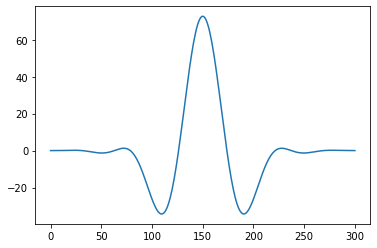

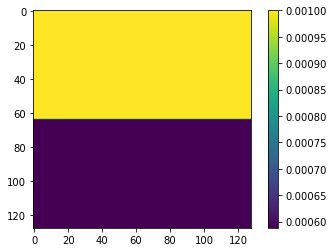

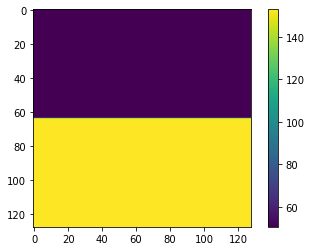

Timestep = 0


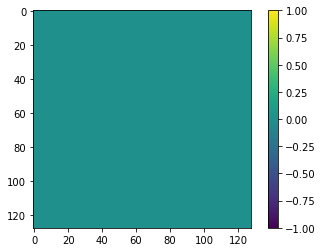

Timestep = 100


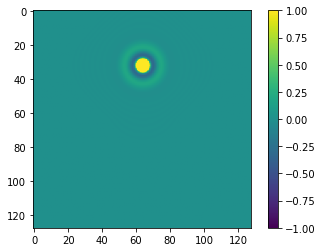

Timestep = 200


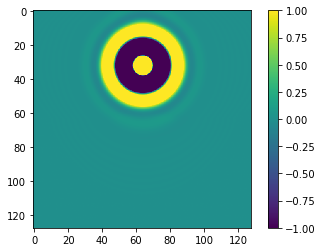

Timestep = 300


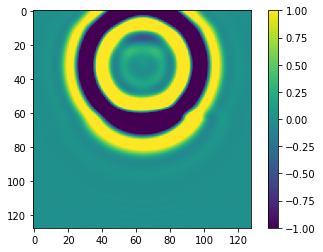

Timestep = 400


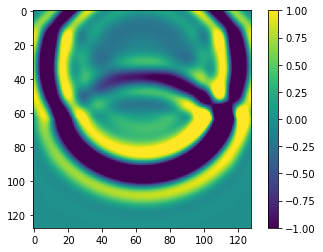

Timestep = 500


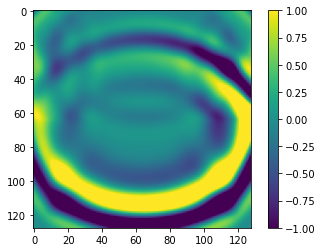

Timestep = 600


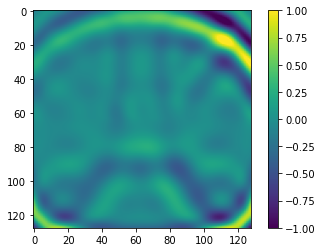

Timestep = 700


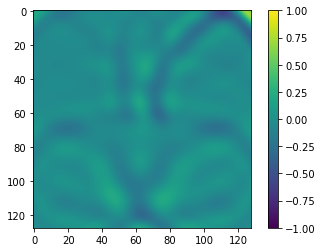

Timestep = 800


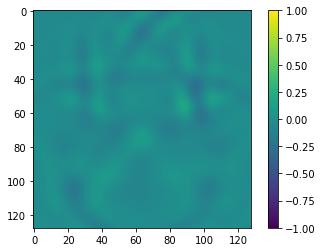

Timestep = 900


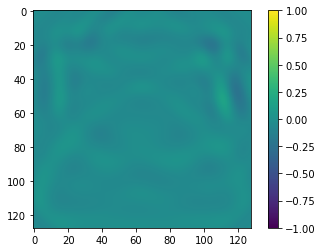

Timestep = 1000


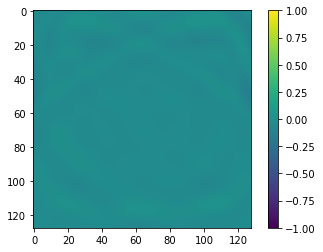

In [15]:
NX = int(128)
NY = int(128)
NZ = int(64)
NT = int(1024)

ORDER  = 8
RHO_U = 1000.; RHO_L = 1700.
VEL_U = 1500.; VEL_L = 2000.
C_CRIT = 0.15 # IVD is less stable than isotropic

DX = 10.
DY = 10.
DT = C_CRIT * DX / VEL # n.b. will change the source frequency

L = NX * DX
T = NT * DT

print("""
Domain length = %.1f m, 
Propagating for T = %.1f s, 
in velocity model of V = %.1f m/s,
using Finite-Difference Order = %d,
Grid params: NX = %d, NT = %d,
DX = %.1f m, DT = %.3f ms, COURANT = %.2f
""" % (L,T,VEL,ORDER,NX,NT,DX,DT*1e3,C_CRIT))

SOURCE = init_src_wavelet(DT) # halved C_CRIT
plt.plot(SOURCE); plt.show()

buoy  = np.zeros((NX,NY,NZ))
kappa = np.zeros((NX,NY,NZ))
u1    = np.zeros((NX,NY,NZ))
u2    = np.zeros((NX,NY,NZ))

buoy[:NX//2,:,:] = 1./RHO_U
buoy[NX//2:,:,:] = 1./RHO_L

kappa[:NX//2,:,:] = RHO_U*VEL_U*VEL_U*DT*DT/DX/DX
kappa[NX//2:,:,:] = RHO_L*VEL_L*VEL_L*DT*DT/DX/DX

plt.imshow(buoy[:,:,NZ//2]);  plt.colorbar(); plt.show()
plt.imshow(kappa[:,:,NZ//2]); plt.colorbar(); plt.show()

iso_vd_extrapolate3d(u1,u2,buoy,kappa,DX,DT,NX,NY,NZ,NT,SOURCE,ORDER)